# Boost vs 딥러닝


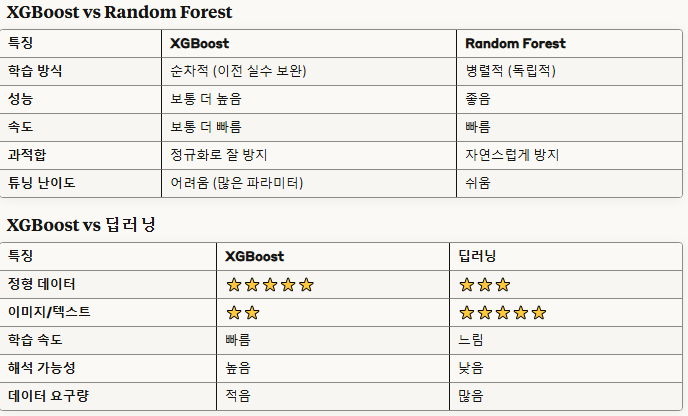

In [1]:
# 나눔고딕 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped dire

In [2]:
import matplotlib.pyplot as plt

# 폰트 설정
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
import matplotlib.pyplot as plt
# 폰트 설정
import matplotlib.font_manager as fm
font_path='/System/Library/Fonts/AppleGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'AppleGothic'  # macOS
plt.rcParams['axes.unicode_minus'] = False

In [25]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# 1. 데이터 로드
df = pd.read_csv('./kbobattingdata.csv')
print(df.head())
print("컬럼:", df.columns)

# 2. 타깃/피처 지정 (홈런 예측)
target_col = 'homeruns'   # 'homeruns'이 홈런수 컬럼명임을 가정
drop_cols = [target_col]
features = [c for c in df.columns if c not in drop_cols]

# 3. 연도, 팀명 문자형 처리(LabelEncoding)
from sklearn.preprocessing import LabelEncoder
for col in ['team']:
    if col in features:
        df[col] = df[col].astype(str)
        df[col] = LabelEncoder().fit_transform(df[col])

# 4. 결측치 처리 (수치형: 평균)
# Identify numeric columns for mean imputation
numeric_cols = df[features].select_dtypes(include=np.number).columns
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].mean())

print(df.head())

X = df[features]
y = df[target_col]

# 5. train/test 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


   year           team  average_batter_age  runs_per_game  games  \
0  2021    SSG Landers                30.9           5.26    143   
1  2021   Doosan Bears                29.0           5.13    143   
2  2021   Lotte Giants                29.0           5.06    143   
3  2021  Kiwoom Heroes                27.1           5.01    143   
4  2021         KT Wiz                29.4           4.97    143   

   plate_appearances  at_bats  runs  hits  doubles  ...  batting_average  \
0               5698     4864   752  1268      203  ...            0.261   
1               5606     4867   733  1306      234  ...            0.268   
2               5689     4978   723  1384      263  ...            0.278   
3               5610     4839   716  1250      243  ...            0.258   
4               5581     4773   711  1263      217  ...            0.265   

     OBP    SLG    OPS  total_bases  GDP  HBP  sacrifice_hits  \
0  0.354  0.421  0.775         2049  104   93              55   
1  0

In [40]:

# 6. XGBoost 회귀모델
import xgboost as xgb
xgb_model = xgb.XGBRegressor(n_estimators=120, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print("\n[ XGBoost - 홈런 예측 ]")
print("MSE:", mean_squared_error(y_test, y_pred_xgb))
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("R2:", r2_score(y_test, y_pred_xgb))


from sklearn.ensemble import GradientBoostingRegressor

gbdt_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
gbdt_model.fit(X_train, y_train)
y_pred_gbdt = gbdt_model.predict(X_test)

print("\n[ GBoost - 홈런 예측 ]")
print("MSE:", mean_squared_error(y_test, y_pred_gbdt))
print("MAE:", mean_absolute_error(y_test, y_pred_gbdt))
print("R2:", r2_score(y_test, y_pred_gbdt))


[ XGBoost - 홈런 예측 ]
MSE: 147.52781677246094
MAE: 9.685372352600098
R2: 0.924406886100769

[ GBoost - 홈런 예측 ]
MSE: 93.82326404921274
MAE: 7.92960585473653
R2: 0.9519250450962227


In [76]:

# 7. 딥러닝(MLP) 회귀모델 (PyTorch)


class BattingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = BattingDataset(X_train, y_train)
test_ds = BattingDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False)

class MLP(nn.Module):
    def __init__(self, in_dim, hidden_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1)
        )
    def forward(self, x):
        return self.net(x)

mlp_model = MLP(X.shape[1], hidden_size=64)
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(50):
    mlp_model.train()
    for xb, yb in train_loader:
        pred = mlp_model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

mlp_model.eval()
y_pred_mlp = []
with torch.no_grad():
    for xb, yb in test_loader:
        y_pred_mlp.extend(mlp_model(xb).view(-1).tolist())
y_pred_mlp = np.array(y_pred_mlp)

print("\n[ MLP 딥러닝 - 홈런 예측 ]")
print("MSE:", mean_squared_error(y_test, y_pred_mlp))
print("MAE:", mean_absolute_error(y_test, y_pred_mlp))
print("R2:", r2_score(y_test, y_pred_mlp))


Epoch 10, Loss: 679.2381
Epoch 20, Loss: 34.3556
Epoch 30, Loss: 737.2784
Epoch 40, Loss: 13.7176
Epoch 50, Loss: 7.3631

[ MLP 딥러닝 - 홈런 예측 ]
MSE: 40.675479821157374
MAE: 5.356929133488582
R2: 0.9791579212479119


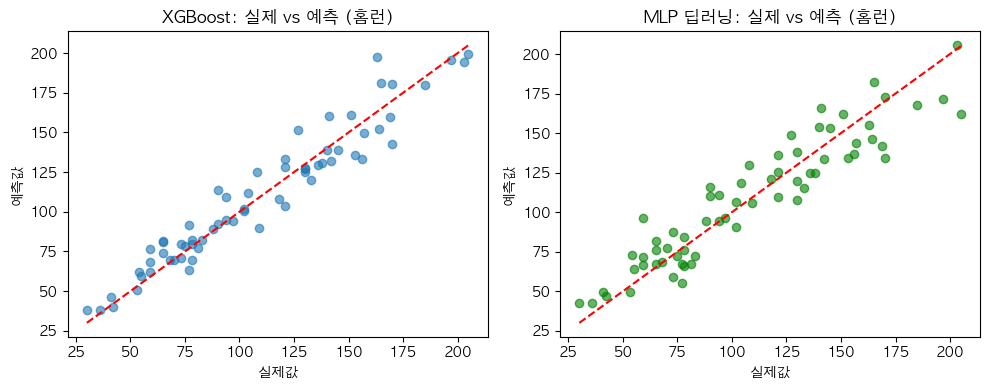

In [9]:

# 8. 실제 vs 예측 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_xgb, alpha=0.6)
plt.title("XGBoost: 실제 vs 예측 (홈런)")
plt.xlabel("실제값")
plt.ylabel("예측값")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_mlp, alpha=0.6, color='green')
plt.title("MLP 딥러닝: 실제 vs 예측 (홈런)")
plt.xlabel("실제값")
plt.ylabel("예측값")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()

In [42]:
# 9. LSTM 모델을 이용한 홈런 예측

# 시계열 데이터로 변환하기 위해 데이터를 sequence 형태로 변환
def create_sequences(X, y, seq_length=5):
    """시계열 sequence 데이터 생성"""
    Xs, ys = [], []
    for i in range(len(X) - seq_length + 1):
        Xs.append(X.iloc[i:i+seq_length].values)
        ys.append(y.iloc[i+seq_length-1])
    return np.array(Xs), np.array(ys)

df_sorted = df.sort_values('year').reset_index(drop=True)
print(f"정렬된 데이터 형태: {df_sorted.shape}")
print("팀별 연도 정렬 확인:")
print(df_sorted[['team', 'year']].head(15))

X_sorted = df_sorted[features]
y_sorted = df_sorted[target_col]

# sequence 길이 설정 (과거 3년간의 데이터를 보고 예측)
seq_length =10

# sequence 데이터 생성
X_seq, y_seq = create_sequences(X_sorted, y_sorted, seq_length)

# train/test 분할 (시계열 특성 고려하여 순차적 분할)
split_idx = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_test_seq = y_seq[:split_idx], y_seq[split_idx:]

print(f"\nLSTM 훈련 데이터 형태: {X_train_seq.shape}")
print(f"LSTM 테스트 데이터 형태: {X_test_seq.shape}")

# LSTM Dataset 클래스
class LSTMDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# LSTM 모델 정의
class LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(LSTM_Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        # LSTM layer
        lstm_out, (hidden, cell) = self.lstm(x)
        # 마지막 시점의 출력 사용
        out = self.fc(lstm_out[:, -1, :])
        return out

# 데이터 로더 생성
lstm_train_ds = LSTMDataset(X_train_seq, y_train_seq)
lstm_test_ds = LSTMDataset(X_test_seq, y_test_seq)
lstm_train_loader = DataLoader(lstm_train_ds, batch_size=16, shuffle=True)
lstm_test_loader = DataLoader(lstm_test_ds, batch_size=16, shuffle=False)

# LSTM 모델 초기화
input_size = X_train_seq.shape[2]  # feature 수
lstm_model = LSTM_Model(input_size=input_size, hidden_size=64, num_layers=2)

# 훈련 설정
optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
criterion_lstm = nn.MSELoss()

print(f"\nLSTM 모델 훈련 시작...")

# LSTM 모델 훈련
lstm_model.train()
for epoch in range(100):
    epoch_loss = 0
    for batch_x, batch_y in lstm_train_loader:
        optimizer_lstm.zero_grad()
        outputs = lstm_model(batch_x)
        loss = criterion_lstm(outputs, batch_y)
        loss.backward()
        optimizer_lstm.step()
        epoch_loss += loss.item()
    
    if (epoch + 1) % 20 == 0:
        avg_loss = epoch_loss / len(lstm_train_loader)
        print(f'Epoch [{epoch+1}/100], Loss: {avg_loss:.4f}')

# LSTM 모델 평가
lstm_model.eval()
y_pred_lstm = []
with torch.no_grad():
    for batch_x, batch_y in lstm_test_loader:
        outputs = lstm_model(batch_x)
        y_pred_lstm.extend(outputs.view(-1).tolist())

y_pred_lstm = np.array(y_pred_lstm)

print("\n[ LSTM - 홈런 예측 ]")
print("MSE:", mean_squared_error(y_test_seq, y_pred_lstm))
print("MAE:", mean_absolute_error(y_test_seq, y_pred_lstm))
print("R2:", r2_score(y_test_seq, y_pred_lstm))

정렬된 데이터 형태: (323, 27)
팀별 연도 정렬 확인:
    team  year
0     18  1982
1     19  1982
2     11  1982
3     10  1982
4      3  1982
5     14  1982
6     18  1983
7     10  1983
8     11  1983
9     14  1983
10     3  1983
11    19  1983
12    18  1984
13     3  1984
14    11  1984

LSTM 훈련 데이터 형태: (251, 10, 26)
LSTM 테스트 데이터 형태: (63, 10, 26)

LSTM 모델 훈련 시작...
Epoch [20/100], Loss: 1715.4424
Epoch [40/100], Loss: 1808.7183
Epoch [60/100], Loss: 1729.6322
Epoch [80/100], Loss: 1683.2699
Epoch [100/100], Loss: 1678.4263

[ LSTM - 홈런 예측 ]
MSE: 2829.070398171298
MAE: 43.162032233344185
R2: -1.0918145889524595


In [52]:
print("\n[ GBDT - 홈런 예측 ]")
print("MSE:", mean_squared_error(y_test, y_pred_gbdt))
print("MAE:", mean_absolute_error(y_test, y_pred_gbdt))
print("R2:", r2_score(y_test, y_pred_gbdt))

print("\n[ XGBoost - 홈런 예측 ]")
print("MSE:", mean_squared_error(y_test, y_pred_xgb))
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("R2:", r2_score(y_test, y_pred_xgb))

print("\n[ MLP 딥러닝 - 홈런 예측 ]")
print("MSE:", mean_squared_error(y_test, y_pred_mlp))
print("MAE:", mean_absolute_error(y_test, y_pred_mlp))
print("R2:", r2_score(y_test, y_pred_mlp))

print("\n[ LSTM - 홈런 예측 ]")
print("MSE:", mean_squared_error(y_test_seq, y_pred_lstm))
print("MAE:", mean_absolute_error(y_test_seq, y_pred_lstm))
print("R2:", r2_score(y_test_seq, y_pred_lstm))


[ GBDT - 홈런 예측 ]
MSE: 93.82326404921274
MAE: 7.92960585473653
R2: 0.9519250450962227

[ XGBoost - 홈런 예측 ]
MSE: 147.52781677246094
MAE: 9.685372352600098
R2: 0.924406886100769

[ MLP 딥러닝 - 홈런 예측 ]
MSE: 82.05908979170154
MAE: 7.623203747089093
R2: 0.9579529972533057

[ LSTM - 홈런 예측 ]
MSE: 2829.070398171298
MAE: 43.162032233344185
R2: -1.0918145889524595
